# Forecasting with Stateful RNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

style.use('ggplot')

In [0]:
def plot_the_series(time_, series_, format_='-', start=0, end=None, label=None):
  plt.plot(time_[start:end], series_[start:end], format_, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")

  if label:
    plt.legend(fontsize=10)

In [0]:
def trend(time_, slope_=0):
  return time_ * slope_

def seasonal_pattern(season_time):
  season_pattern_arr = np.where(season_time < 0.4, 
                                np.cos(season_time * 2 * np.pi), 
                                1 / np.exp(3 * season_time))
  return season_pattern_arr

def seasonality(time_, period, amplitude=1, phase=0):
  season_time = ((time_ + phase) % period) / period
  seasonality_added = amplitude * seasonal_pattern(season_time=season_time)
  return seasonality_added

def white_noise(time_, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed=seed)
  noise_arr = rnd.randn(len(time_)) * noise_level
  return noise_arr

In [0]:
amplitude = 40
baseline = 10
slope_ = 0.05

time_ = np.arange(4 * 365 + 1)
series_ = baseline + trend(time_=time_, slope_=slope_) + seasonality(time_=time_, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time_=time_, noise_level=noise_level, seed=42)

series_ += noise

In [8]:
print(time_)
print(series_)

[   0    1    2 ... 1458 1459 1460]
[ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008]


In [9]:
print(time_.shape)
print(series_.shape)

(1461,)
(1461,)


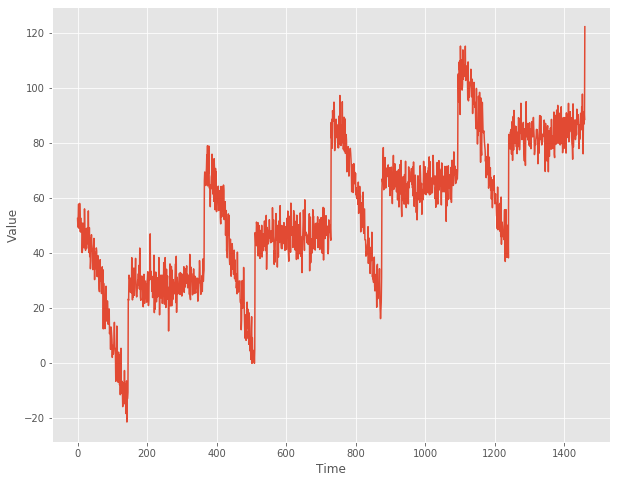

In [10]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_, series_=series_)
plt.show()

In [11]:
split_time = 1000

time_train = time_[:split_time]
x_train = series_[:split_time]

time_valid = time_[split_time:]
x_valid = series_[split_time:]

print("Number of observations in training examples   : {}".format(len(x_train)))
print("Number of observations in validation examples : {}".format(len(x_valid)))

Number of observations in training examples   : 1000
Number of observations in validation examples : 461


### Data Pipeline

In [0]:
def sequential_windowed_data(series_, window_size):
  series_ = tf.expand_dims(input=series_, axis=-1)

  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size+1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[1:]))
  dataset = dataset.batch(batch_size=1).prefetch(1)
  return dataset

In [13]:
for feature, label in sequential_windowed_data(series_=tf.range(10), window_size=3):
  print(feature.numpy())
  print(label.numpy())
  print("Feature shape : {}; Label shape : {}\n".format(feature.shape, label.shape))

[[[0]
  [1]
  [2]]]
[[[1]
  [2]
  [3]]]
Feature shape : (1, 3, 1); Label shape : (1, 3, 1)

[[[3]
  [4]
  [5]]]
[[[4]
  [5]
  [6]]]
Feature shape : (1, 3, 1); Label shape : (1, 3, 1)

[[[6]
  [7]
  [8]]]
[[[7]
  [8]
  [9]]]
Feature shape : (1, 3, 1); Label shape : (1, 3, 1)



### Reset States Call Back

In [0]:
class ResetStateCallBack(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

### Stateful RNN Forecasting

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = sequential_windowed_data(series_=x_train, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(units=100, 
                            return_sequences=True, 
                            stateful=True, 
                            batch_input_shape=[1, None, 1]), 
  tf.keras.layers.SimpleRNN(units=100, 
                            return_sequences=True, 
                            stateful=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
reset_states = ResetStateCallBack()

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, None, 100)            10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (1, None, 100)            20100     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model_1.fit(training_set, 
                      epochs=100, 
                      callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 4s 131ms/step - loss: 105.9339 - mae: 106.4339
Epoch 2/100
33/33 [==============================] - 2s 50ms/step - loss: 72.1532 - mae: 71.3570
Epoch 3/100
33/33 [==============================] - 2s 49ms/step - loss: 40.7396 - mae: 40.3047
Epoch 4/100
33/33 [==============================] - 2s 49ms/step - loss: 27.6156 - mae: 27.8404
Epoch 5/100
33/33 [==============================] - 2s 48ms/step - loss: 24.7553 - mae: 24.9892
Epoch 6/100
33/33 [==============================] - 2s 49ms/step - loss: 23.5799 - mae: 23.7517
Epoch 7/100
33/33 [==============================] - 2s 48ms/step - loss: 22.4292 - mae: 22.5533
Epoch 8/100
33/33 [==============================] - 2s 49ms/step - loss: 21.2604 - mae: 21.3463
Epoch 9/100
33/33 [==============================] - 2s 49ms/step - loss: 20.2543 - mae: 20.3245
Epoch 10/100
33/33 [==============================] - 2s 52ms/step - loss: 19.3646 - mae: 19.4319
Epoch 11/100
33/33 [======

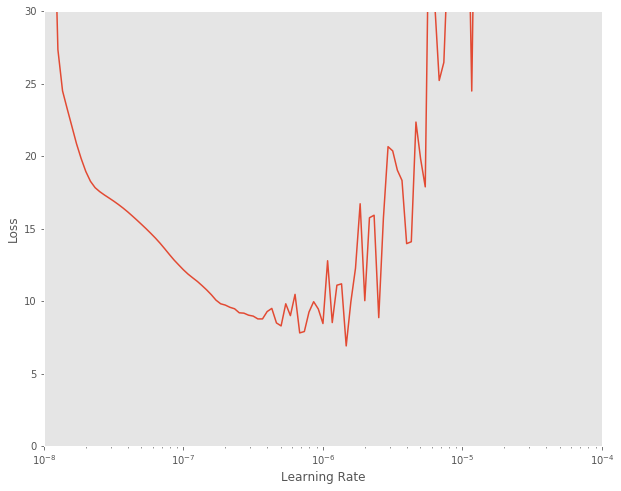

In [21]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = sequential_windowed_data(series_=x_train, window_size=window_size)
validation_set = sequential_windowed_data(series_=x_valid, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(units=100, 
                            return_sequences=True, 
                            stateful=True, 
                            batch_input_shape=[1, None, 1]), 
  tf.keras.layers.SimpleRNN(units=100, 
                            return_sequences=True, 
                            stateful=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
reset_states = ResetStateCallBack()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [26]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, None, 100)            10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (1, None, 100)            20100     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_checkpoint.h5', save_best_only=True)

In [28]:
model_1.fit(training_set, 
            epochs=500, 
            validation_data=validation_set, 
            callbacks=[early_stopping, reset_states, model_checkpoints])

Epoch 1/500
33/33 [==============================] - 4s 117ms/step - loss: 60.2497 - mae: 60.7477 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
33/33 [==============================] - 2s 50ms/step - loss: 25.2905 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 2s 52ms/step - loss: 21.8154 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 2s 49ms/step - loss: 20.4004 - mae: 18.0143 - val_loss: 10.4489 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 2s 50ms/step - loss: 19.5471 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 2s 51ms/step - loss: 18.6853 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 2s 53ms/step - loss: 17.9377 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [===========================

In [0]:
model_1 = tf.keras.models.load_model(filepath='./best_model_checkpoint.h5')

In [30]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, None, 100)            10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (1, None, 100)            20100     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_1.reset_states()
stateful_rnn_forecasts = model_1.predict(x=series_[np.newaxis, :, np.newaxis])

In [32]:
print(stateful_rnn_forecasts)
print(stateful_rnn_forecasts.shape)

[[[197.2895  ]
  [140.2351  ]
  [ 72.652084]
  ...
  [ 85.38843 ]
  [ 84.19936 ]
  [ 88.0914  ]]]
(1, 1461, 1)


In [0]:
stateful_rnn_forecasts_1D = stateful_rnn_forecasts[0, split_time-1:-1, 0]

In [34]:
print(stateful_rnn_forecasts_1D)
print(stateful_rnn_forecasts_1D.shape)

[62.599747 71.34603  70.232185 64.78379  61.42557  64.80268  68.244484
 67.1327   67.33627  68.48988  64.6629   65.703224 68.69213  70.18058
 65.94885  65.83127  69.34816  62.946384 59.893215 63.71604  65.18607
 66.954544 63.15456  61.975372 71.06243  74.982315 67.70113  63.669117
 65.37778  67.643425 63.049732 60.087723 59.77874  61.204456 68.47993
 64.48516  65.73662  65.23585  56.06646  61.44602  71.06621  71.18667
 65.35197  64.913055 68.34337  64.44319  66.460625 70.03347  60.979675
 62.996346 74.689316 65.94727  61.75441  68.78417  67.91692  63.350002
 61.40858  64.10734  69.4747   69.35875  64.150795 65.71791  58.95303
 58.31904  64.905754 59.210323 60.678734 60.286022 64.74681  68.24787
 63.395287 65.92157  67.42182  66.908356 61.82062  64.3119   68.286766
 59.20648  59.25157  71.25055  72.09528  64.7052   62.531376 65.31428
 71.84414  71.93889  66.42367  69.21017  70.208534 65.40243  64.764
 66.291145 66.50604  68.214424 68.24068  68.02568  82.951904 94.62663
 86.39918  84.826

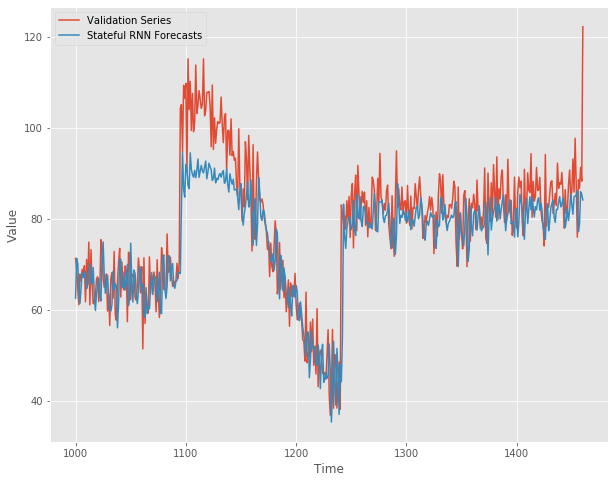

In [37]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=stateful_rnn_forecasts_1D, label="Stateful RNN Forecasts")
plt.show()

In [38]:
stateful_rnn_forecasts_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=stateful_rnn_forecasts_1D).numpy()
stateful_rnn_forecasts_mae

6.2778316